# Linear SDOF PINN

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \ddot{x} + c \dot{x} + kx = F_x~, \qquad \ddot{x} + \tilde{c} \dot{x} + \tilde{k}x = \tilde{F}_x~, \qquad \tilde{\bullet} = \frac{\bullet}{m}
$$
with the initial conditions and forcing,
$$
x(0) = 10\mathrm{mm}~~,~~\dot{x}(0) = 0, \qquad F_x = F_0\sin(\omega_t)
$$
<!-- This has the following exact solution:
$$
x(t) = e^{-\zeta \omega_n t} \left[ x_0 \cos(\omega_dt) + \left( \frac{\dot{x}_0+\zeta \omega_nx_0}{\omega_d} \right)\sin(\omega_dt) \right], \qquad \omega_d = \omega_n\sqrt{1-\zeta^2}
$$
where,
$$
\omega_n = \sqrt{\frac{k}{m}}=\sqrt{\tilde{k}}, \qquad \zeta=\frac{c}{2m\omega_n} = \frac{\tilde{c}}{2\sqrt{\tilde{k}}}
$$ -->

<!-- ## State Space Formulation
$$ \dot{\mathbf{\tau}}(t) = \mathbf{A}\mathbf{\tau}(t) + \mathbf{B}\mathbf{f}(t) $$
where,
$$  \mathbf{\tau}(t) = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}, \quad
    \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -m^{-1}k & -m^{-1}c \end{bmatrix}, \quad
    \mathbf{B} = \begin{bmatrix} 0 \\ m^{-1} \end{bmatrix} $$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} x(t) \\ \ddot{x}(t) \end{bmatrix} $$ -->

In [1]:
from sdof_pinn import bbnn, sdof_pinn, normalise
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Generate forcing

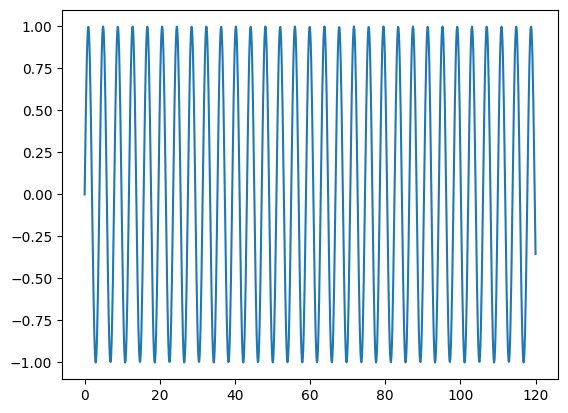

In [2]:
nt = 1024
t = np.linspace(0,120,nt)

F0 = 1.0  # N

excitation = {
    "type" : "sinusoid",
    "F0" : F0,
    "w" : 1.6  # rad/s
}

# excitation = {
#     "type" : "rand_phase_multisine",
#     "F0" : F0,
#     "freqs" :   np.array([0.7, 1.8]),
#     "Sx" :      np.array([1.0, 1.0])
# }

# excitation = {
#     "type" : "sine_sweep",
#     "F0" : F0,
#     "w" :   np.array([0.4, 1.8]),
#     "scale" :  "linear"
# }

F = generate_excitation(t, **excitation)
excitation["F"] = F.reshape(-1)

fig, ax = plt.subplots()
ax.plot(t, F)

### Generate training data

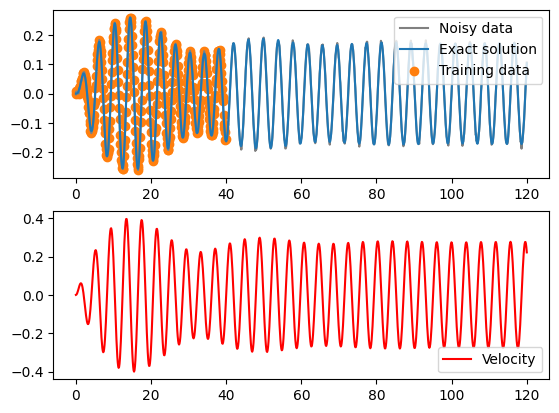

In [3]:
m = 10.0
c = 1.0
k = 20.0
excitation["F_tild"] = torch.tensor(excitation["F"]/m)

wn = np.sqrt(k/m)
zeta = c/(2*m*wn)
wd = wn*np.sqrt(1-zeta**2)

c_tild = c/m
k_tild = k/m
F_tild = F/m

gt_config = {
    "nonlinearity" : "linear",
    # "m_norm" : False,
    # "params" : {
    #     "m" : m,
    #     "k" : k,
    #     "c" : c
    # },
    "m_norm" : True,
    "params" : {
        "k_tild" : k_tild,
        "c_tild" : c_tild
    },
    "init_conds" : {
        "x0" : 0.0,
        "v0" : 0.0
    },
    "forcing" : excitation
}

x, v = sdof_solution(t, **gt_config)
x_noisy = add_noise(x.view(-1,1), 0.02)
t = torch.tensor(t).view(-1,1).to(torch.float32)

# slice out a number of points from the start of the signal
sub_ind = np.arange(0, int(nt/3), 1)

t_data = t[sub_ind]
x_data = x_noisy[sub_ind]

fig, axs= plt.subplots(2,1)
axs[0].plot(t, x_noisy, color="gray", label="Noisy data")
axs[0].plot(t, x, label="Exact solution")
axs[0].scatter(t_data, x_data, color="tab:orange", label="Training data")
axs[0].legend()

# axs[1].plot(t, F_tild, color="red", label="Forcing")
axs[1].plot(t, v, color="red", label="Velocity")
axs[1].legend()

Normalise

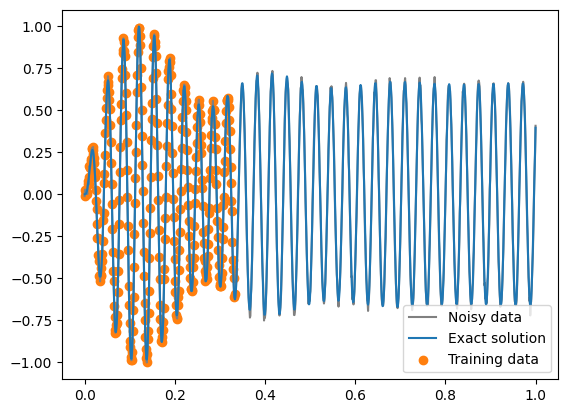

In [46]:
t_hat, alpha_t = normalise(t, "range")
x_hat, alpha_x = normalise(x_noisy, "range")
F_hat, alpha_F = normalise(F_tild, "range")
excitation["F_hat"] = F_hat
x_hat_gt = x/alpha_x
t_data = t_hat[sub_ind]
x_data = x_hat[sub_ind]
alphas = {
    "t" : alpha_t,
    "x" : alpha_x
}

fig, ax = plt.subplots()
ax.plot(t_hat, x_hat, color="gray", label="Noisy data")
ax.plot(t_hat, x_hat_gt, label="Exact solution")
ax.scatter(t_data, x_data, color="tab:orange", label="Training data")
ax.legend()

## 'Black-box' network

$$
\textrm{argmin}\mathcal{L}(t;\mathbf{\theta}) := \langle \hat{x}^* - \mathcal{N}_x \rangle
$$

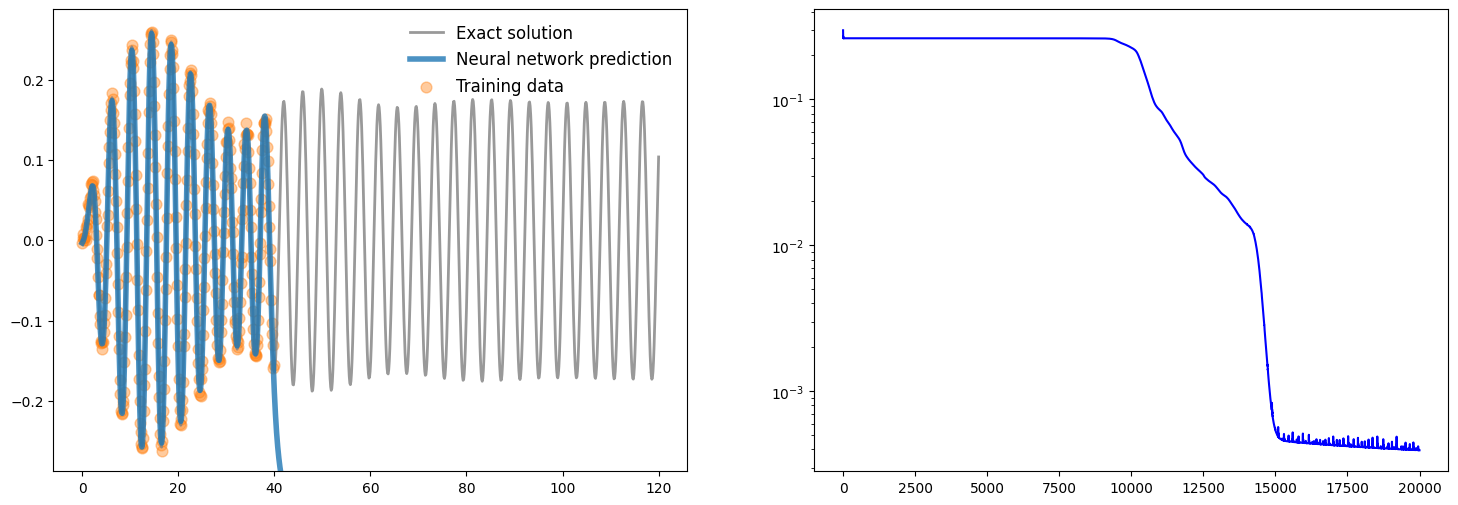

In [47]:
def plot_result(ax, t_hat, x_hat, t_data, x_data, tpred, xpred, alphas):
    ax.cla()
    ax.plot(t_hat*alphas["t"], x_hat*alphas["x"], color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    ax.plot(tpred*alphas["t"], xpred*alphas["x"], color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    ax.scatter(t_data*alphas["t"], x_data*alphas["x"], s=60, color="tab:orange", alpha=0.4, label='Training data')
    l = ax.legend(frameon=False, fontsize="large")
    xL = torch.amax(t_hat)*alphas["t"]
    yL = torch.amax(torch.abs(x_hat))*alphas["x"]
    ax.set_xlim(-0.05*xL, 1.05*xL)
    ax.set_ylim(-1.1*yL, 1.1*yL)

def plot_loss_hist(ax,loss_hist):
    ax.cla()
    n_epoch = len(loss_hist)
    ax.plot(np.arange(1,n_epoch+1),loss_hist,'b')
    ax.set_yscale('log')
    
# train standard neural network to fit training data
torch.manual_seed(123)
epochs = int(20e3)
bb_model = bbnn(1,1,32,2)
optimizer = torch.optim.Adam(bb_model.parameters(),lr=1e-3)
loss_hist = []
fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = bb_model.loss_func(t_data, x_data)
    loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 500 == 0:
        
        xpred = bb_model(t_hat).detach()
        
        plot_result(axs[0], t_hat, x_hat_gt, t_data, x_data, t_hat, xpred, alphas)

        plot_loss_hist(axs[1],loss_hist)
        display.clear_output(wait=True)
        display.display(plt.gcf())

display.clear_output()

## PINN

$$
\textrm{argmin}\mathcal{L}(t;\mathbf{\theta}) = \mathcal{L}_a + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_a = \langle \hat{x}^* - \mathcal{N}_{\hat{x}} \rangle _{\Omega_a}, \qquad
\mathcal{L}_{ode} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} - \eta \hat{F}\rangle _{\Omega_d}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{\alpha_x}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\alpha_x\tilde{k} \hat{x} - 
\alpha_F \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

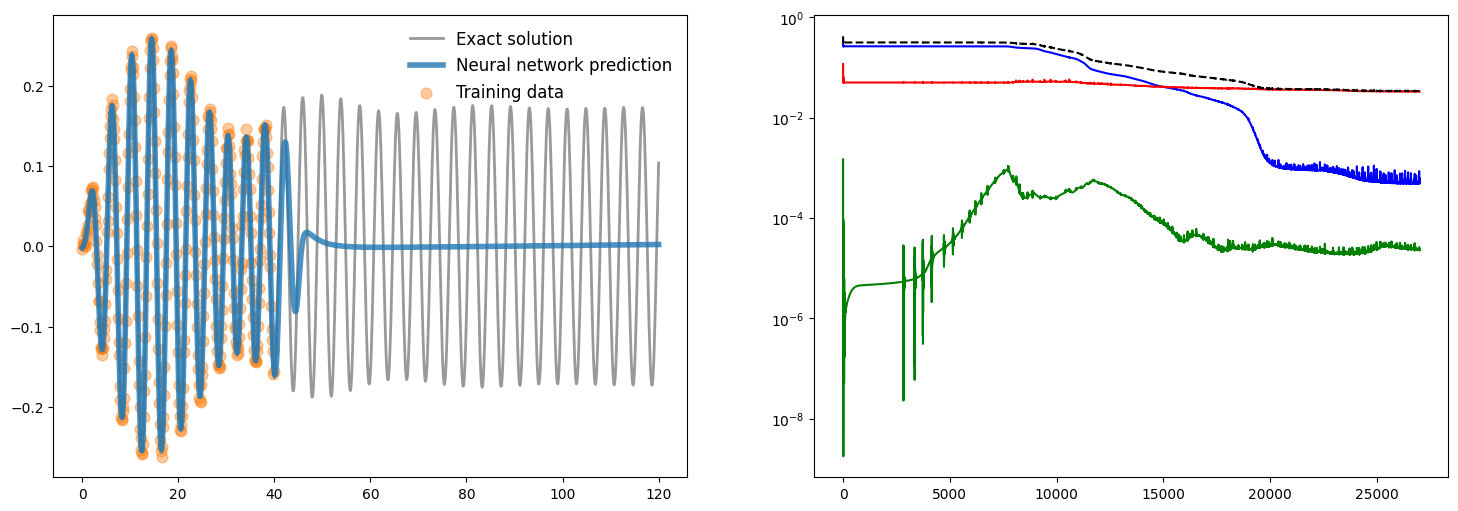

  3%|▎         | 27058/1000000 [00:52<39:47, 407.49it/s]

Epoch : 27000 ---- Loss: 3.36e-02


  3%|▎         | 27183/1000000 [00:52<31:17, 518.20it/s]


KeyboardInterrupt: 

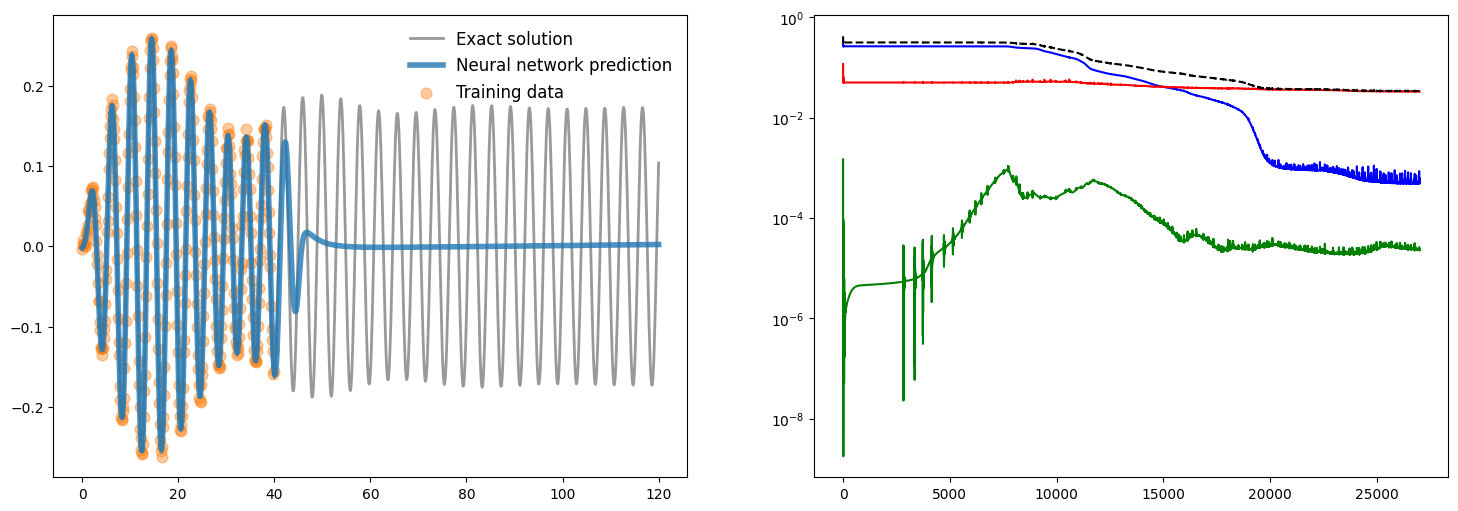

In [57]:
alpha_c = c_tild*10
alpha_k = k_tild*10
alphas = {
    "c" : alpha_c,
    "k" : alpha_k,
    "t" : alpha_t,
    "x" : alpha_x,
    "F" : alpha_F
}

def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    ax.cla()
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,0],'b',label="Observation loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,1],'g',label="IC loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,2],'r',label="Physics loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,3],'k--',label="Total loss")
    ax.set_yscale('log')

torch.manual_seed(123)
pi_model = sdof_pinn(
    N_INPUT = 1,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 2
    )

pinn_config = {
    "nonlinearity" : "linear",
    "phys_params" : {
        "par_type" : "constant",
        "k": k_tild,
        "c" : c_tild
    },
    "init_conds" : gt_config["init_conds"],
    "alphas" : alphas,
    "ode_norm_Lambda" : 1.0,
    "forcing" : excitation
}

# configure pinn
pi_model.configure(**pinn_config)

ntp = nt  # number of collocation points
t_physics = torch.linspace(0, torch.max(t_hat), ntp).view(-1,1).requires_grad_()

epochs = int(1e6)
betas = (0.9,0.999)
optimizer = torch.optim.Adam(pi_model.parameters(),lr=2.5e-3,betas=betas)

fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
loss_hist=[]
lambds = {
    'obs' : torch.tensor(1.0),
    'ic' : torch.tensor(1.0),
    'ode' : torch.tensor(10.0)
}

for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    loss, losses = pi_model.loss_func(t_physics, t_data, x_data, lambds)

    loss_hist.append([losses[0].item(), losses[1].item(), losses[2].item(), loss.item()])
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 500 == 0: 
        
        xpred = pi_model(t_physics).detach()
        
        plot_result(axs[0], t_hat, x_hat_gt, t_data, x_data, t_physics.detach(), xpred, alphas)

        plot_joint_loss_hist(axs[1],np.array(loss_hist))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        match pi_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k']))

display.clear_output()
match pi_model.param_type:
            case "constant":
                tqdma.write("Epochs : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epochs : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k']))

In [58]:
checkpoint = {
    'epoch' : i,
    'model' : pi_model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'loss' : loss_hist,
    # 'scheduler' : scheduler
}

torch.save(checkpoint,'checkpoints/sdof_forced_linear.pth')

  0%|          | 0/500000 [00:00<?, ?it/s]

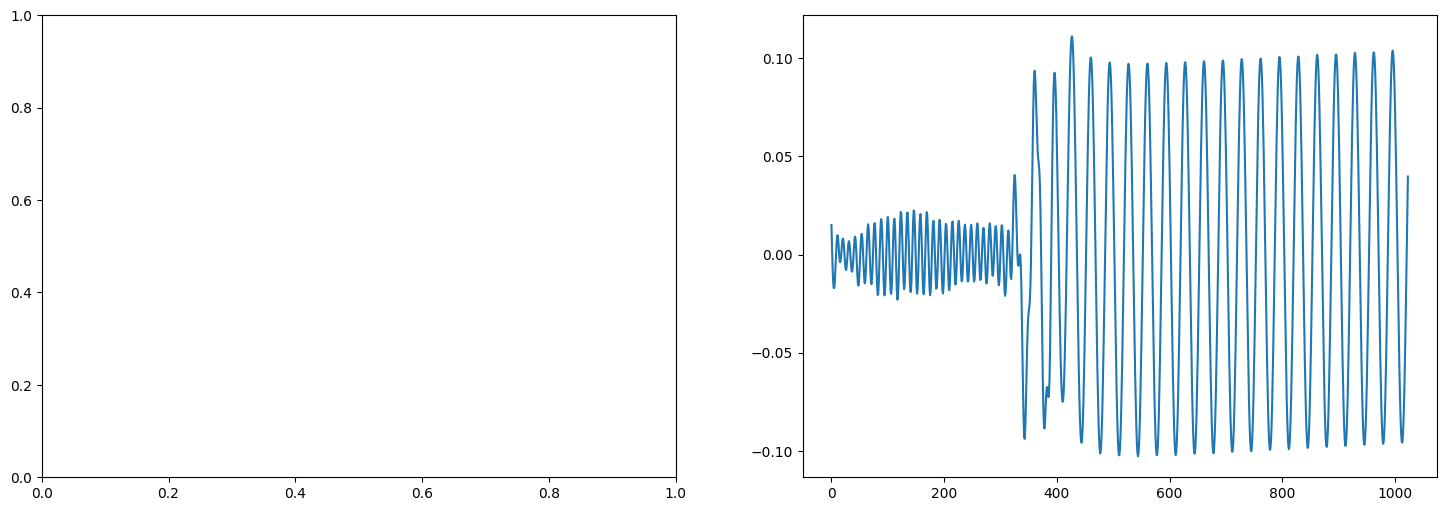

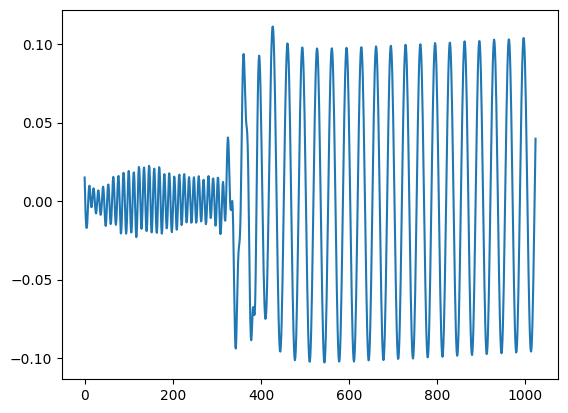

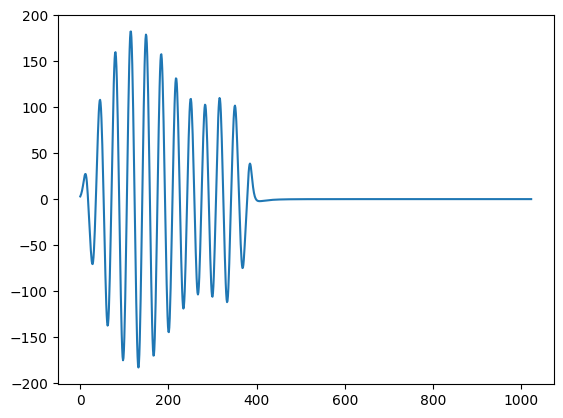

In [60]:
checkpoint = torch.load('checkpoints/sdof_forced_linear.pth')
loss_hist = checkpoint['loss']
pi_model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# for g in optimizer.param_groups:
#     g['lr'] = 1e-4

fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
epochs = int(500e3)

# lambds = {
#     'obs' : torch.tensor(1.0),
#     'ode' : torch.tensor(5e-2)
# }

for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    loss, losses = pi_model.loss_func(t_physics, t_data, x_data, lambds)

    loss_hist.append([losses[0].item(), losses[1].item(), losses[2].item(), loss.item()])
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 500 == 0: 
        
        xpred = pi_model(t_physics).detach()
        
        plot_result(axs[0], t_hat, x_hat_gt, t_data, x_data, t_physics.detach(), xpred, alphas)

        plot_joint_loss_hist(axs[1],np.array(loss_hist))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        match pi_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k']))

display.clear_output()
match pi_model.param_type:
            case "constant":
                tqdma.write("Epochs : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epochs : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k']))